In [35]:
# Config dict to set the logging level
import logging.config
DEFAULT_LOGGING = {
    'version': 1,
    'disable_existing_loggers': False,
    'loggers': {
        '': {
            'level': 'DEBUG',
        },
    }
}

logging.config.dictConfig(DEFAULT_LOGGING)
# Disabling warnings output
import warnings
from sklearn.exceptions import DataConversionWarning, ConvergenceWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
warnings.filterwarnings(action='ignore', category=UserWarning)

#!pip install dowhy
import dowhy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pygraphviz
from causalnex.structure.notears import from_pandas
from causalnex.plots import plot_structure, NODE_STYLE, EDGE_STYLE

In [36]:
df = pd.read_csv('loans_causal_schema.csv')
df.head(5)

,emp_length,state,homeownership,annual_income,debt_to_income,delinq_2y,earliest_credit_line,inquiries_last_12m,total_credit_lines,open_credit_lines,...,delinquent_history,credit_duration,has_credit_inquiries_last_12m,has_collection_accounts,has_accounts_opened_24m,has_bankrupt_history,has_past_due_accounts,debt_limit_exceded,is_bad_loan,is_homeowner
0,3.0,NJ,MORTGAGE,90000.0,18.01,0,2001,6,28,10,...,True,20,True,True,True,False,False,True,False,True
1,10.0,HI,RENT,40000.0,5.04,0,1996,1,30,14,...,True,25,True,False,True,True,False,False,False,False
2,3.0,WI,RENT,40000.0,21.15,0,2006,4,31,10,...,True,15,True,True,True,False,False,False,False,False
3,1.0,PA,RENT,30000.0,10.16,0,2007,0,4,4,...,True,14,False,False,True,False,False,True,False,False
4,10.0,CA,RENT,35000.0,57.96,0,2008,7,22,16,...,True,13,True,False,True,False,False,False,False,False


In [37]:
#remove unneccessary fields
df.drop(['open_credit_lines', 'total_credit_lines', 
         'total_credit_utilized', 'total_credit_limit',
         'num_accounts_120d_past_due','num_accounts_30d_past_due',
         'num_open_cc_accounts','num_total_cc_accounts',
         ], axis=1, inplace=True)

df.drop(['account_never_delinq_percent','delinq_2y','earliest_credit_line','total_collection_amount_ever',
         'accounts_opened_24m','public_record_bankrupt','num_accounts_past_due','inquiries_last_12m'], axis=1, inplace=True)
df.drop(['loan_status','homeownership'], axis=1, inplace=True)

# we have to remove/fix missing values
df['debt_to_income'] = df['debt_to_income'].interpolate()
df['credit_utilization'] = df['credit_utilization'].interpolate()
df  = df.dropna()

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9183 entries, 0 to 9999
Data columns (total 28 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   emp_length                     9183 non-null   float64
 1   state                          9183 non-null   object 
 2   annual_income                  9183 non-null   float64
 3   debt_to_income                 9183 non-null   float64
 4   num_satisfactory_accounts      9183 non-null   int64  
 5   num_active_debit_accounts      9183 non-null   int64  
 6   total_debit_limit              9183 non-null   int64  
 7   num_cc_carrying_balance        9183 non-null   int64  
 8   num_mort_accounts              9183 non-null   int64  
 9   loan_amount                    9183 non-null   int64  
 10  term                           9183 non-null   int64  
 11  interest_rate                  9183 non-null   float64
 12  installment                    9183 non-null   f

In [39]:
import numpy as np
struct_data = df.copy()

non_numeric_columns = list(struct_data.select_dtypes(exclude=[np.number]).columns)
print(non_numeric_columns)

['state', 'delinquent_history', 'has_credit_inquiries_last_12m', 'has_collection_accounts', 'has_accounts_opened_24m', 'has_bankrupt_history', 'has_past_due_accounts', 'debt_limit_exceded', 'is_bad_loan', 'is_homeowner']


In [40]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
for col in non_numeric_columns:
    struct_data[col] = le.fit_transform(struct_data[col])

struct_data.head(5)

,emp_length,state,annual_income,debt_to_income,num_satisfactory_accounts,num_active_debit_accounts,total_debit_limit,num_cc_carrying_balance,num_mort_accounts,loan_amount,...,delinquent_history,credit_duration,has_credit_inquiries_last_12m,has_collection_accounts,has_accounts_opened_24m,has_bankrupt_history,has_past_due_accounts,debt_limit_exceded,is_bad_loan,is_homeowner
0,3.0,30,90000.0,18.01,10,2,11100,6,1,28000,...,1,20,1,1,1,0,0,1,0,1
1,10.0,11,40000.0,5.04,14,3,16500,4,0,5000,...,1,25,1,0,1,1,0,0,0,0
2,3.0,47,40000.0,21.15,10,3,4300,6,0,2000,...,1,15,1,1,1,0,0,0,0,0
3,1.0,37,30000.0,10.16,4,2,19400,2,0,21600,...,1,14,0,0,1,0,0,1,0,0
4,10.0,4,35000.0,57.96,16,10,32700,13,0,23000,...,1,13,1,0,1,0,0,0,0,0


In [41]:
from causalnex.structure.notears import from_pandas
sm = from_pandas(struct_data,max_iter=100)

INFO:root:Learning structure using 'NOTEARS' optimisation.
/home/bhakthi/PhD/causalai/venv/lib/python3.8/site-packages/causalnex/structure/notears.py:395: RuntimeWarning: overflow encountered in double_scalars
  return loss + 0.5 * rho * h * h + alpha * h
/home/bhakthi/PhD/causalai/venv/lib/python3.8/site-packages/causalnex/structure/notears.py:411: RuntimeWarning: overflow encountered in multiply
  obj_grad = loss_grad + (rho * (np.trace(E) - d) + alpha) * E.T * W * 2
/home/bhakthi/PhD/causalai/venv/lib/python3.8/site-packages/causalnex/structure/notears.py:411: RuntimeWarning: invalid value encountered in multiply
  obj_grad = loss_grad + (rho * (np.trace(E) - d) + alpha) * E.T * W * 2


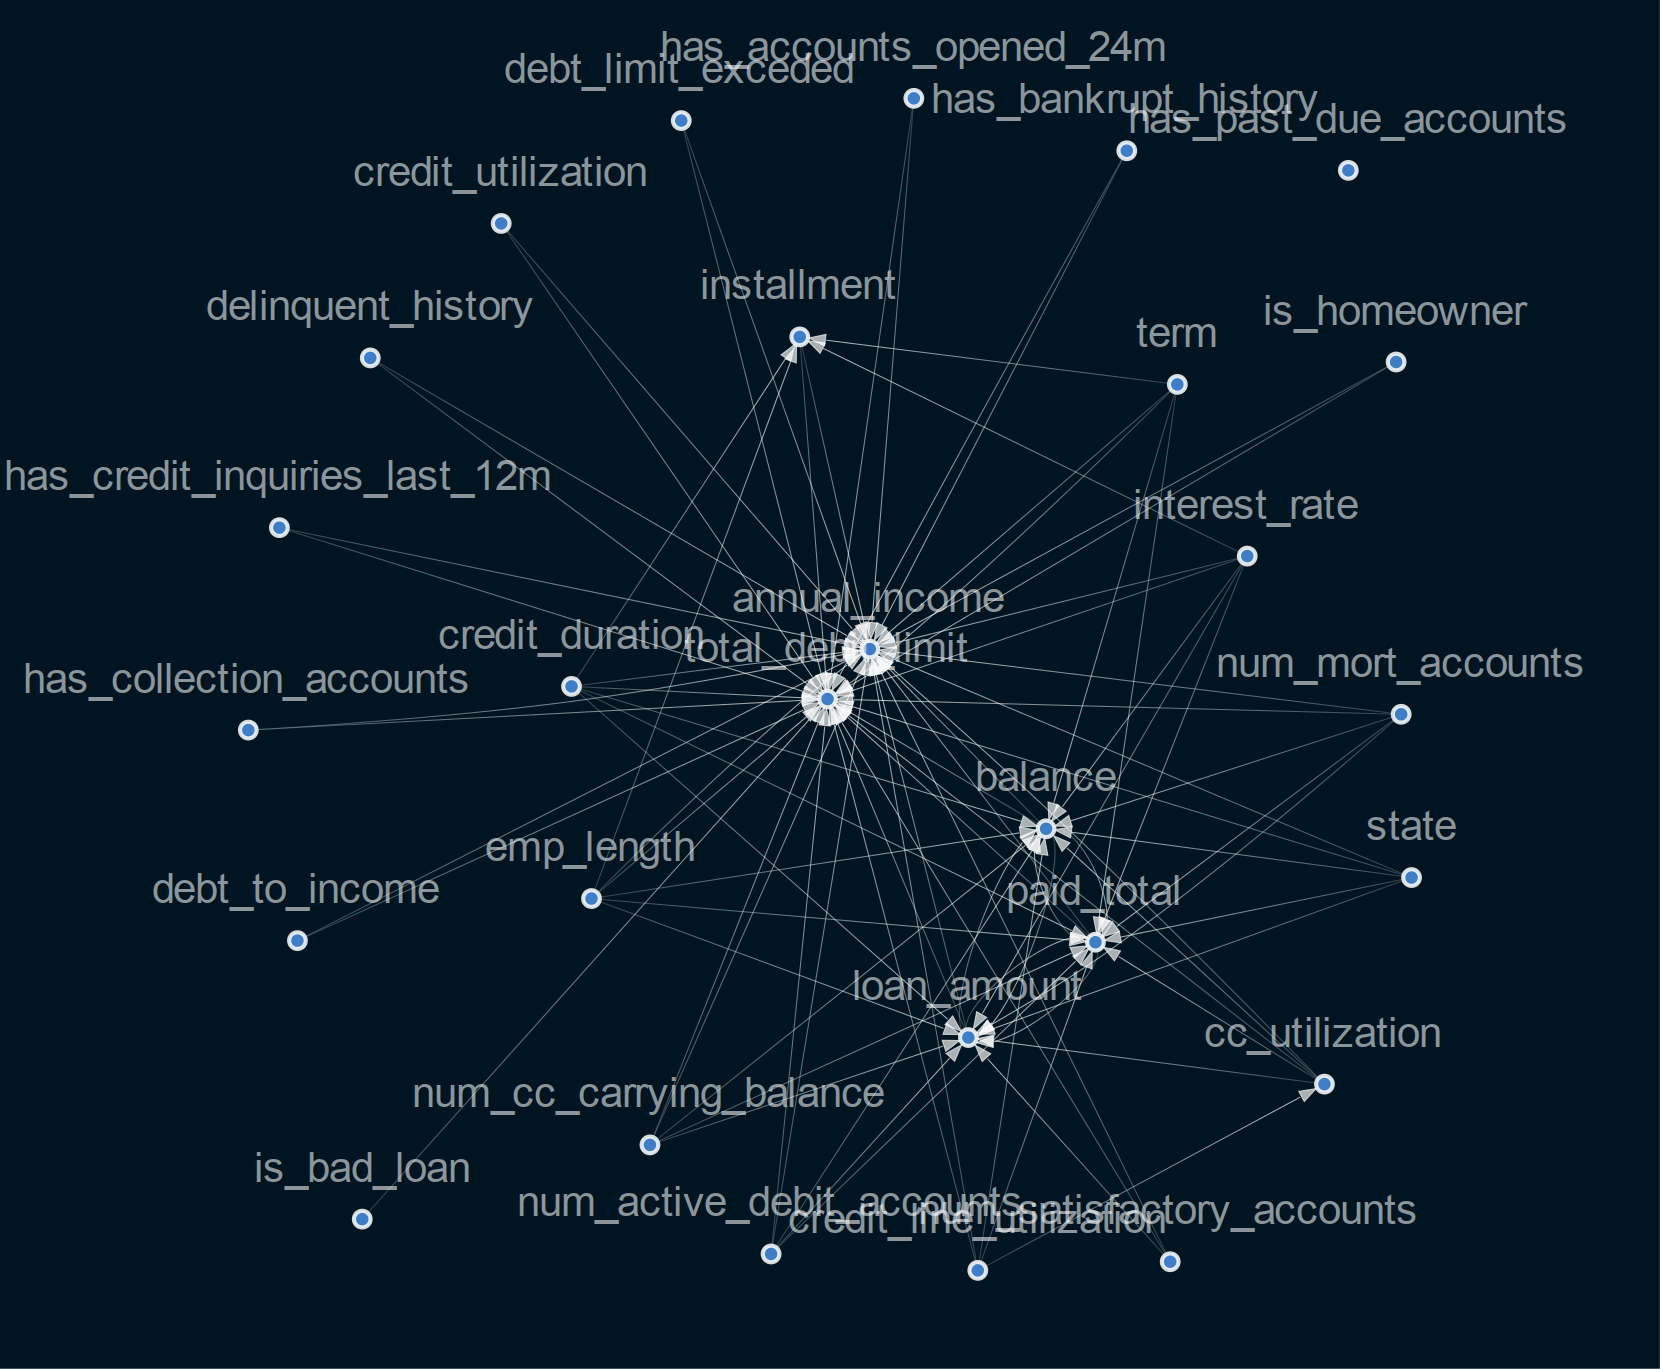

In [59]:
from IPython.display import Image
from causalnex.plots import plot_structure, NODE_STYLE, EDGE_STYLE
viz = plot_structure(
    sm,
    graph_attributes={"scale": "0.5"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK)
Image(viz.draw(format='png'))

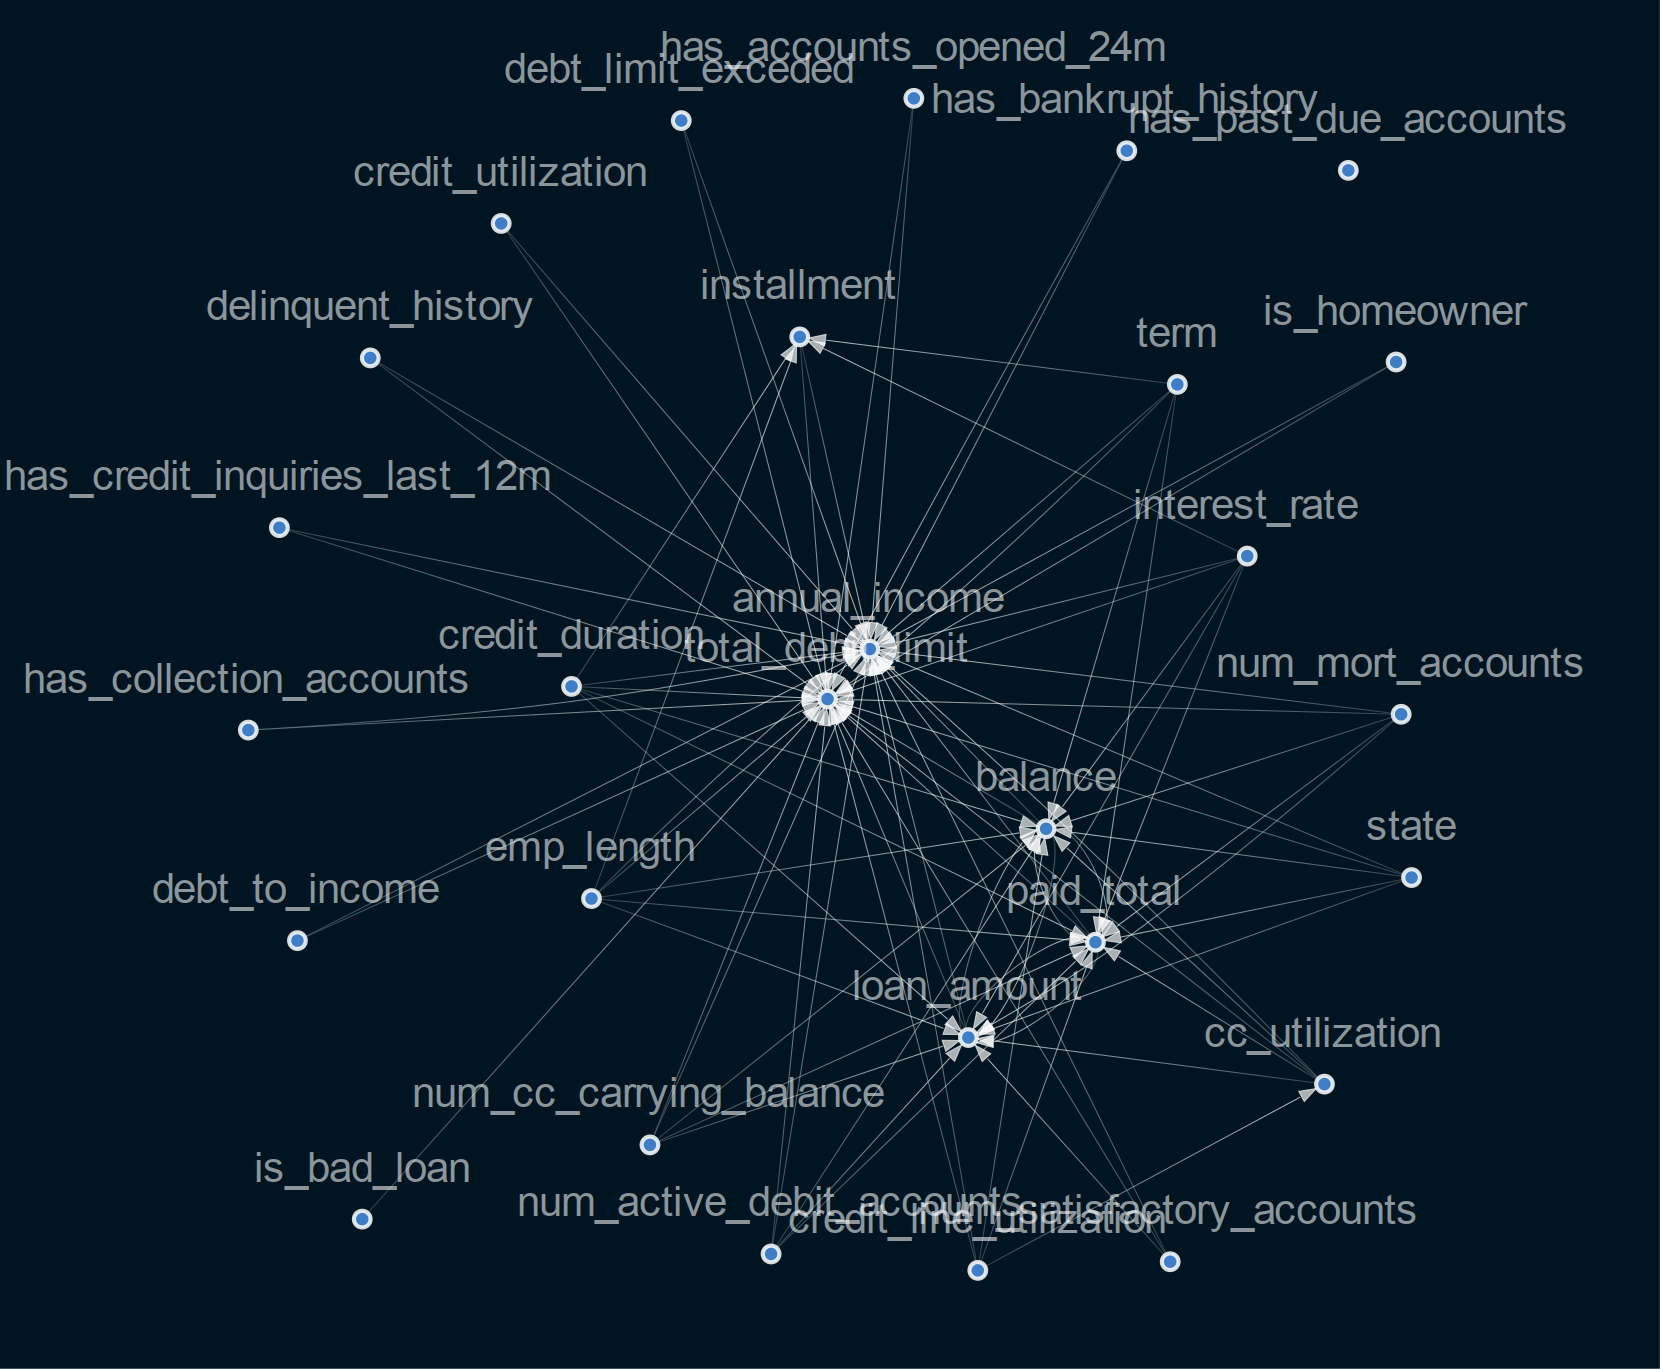

In [60]:
sm.remove_edges_below_threshold(0.9)
viz = plot_structure(
    sm,
    graph_attributes={"scale": "0.5"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK)
Image(viz.draw(format='png'))

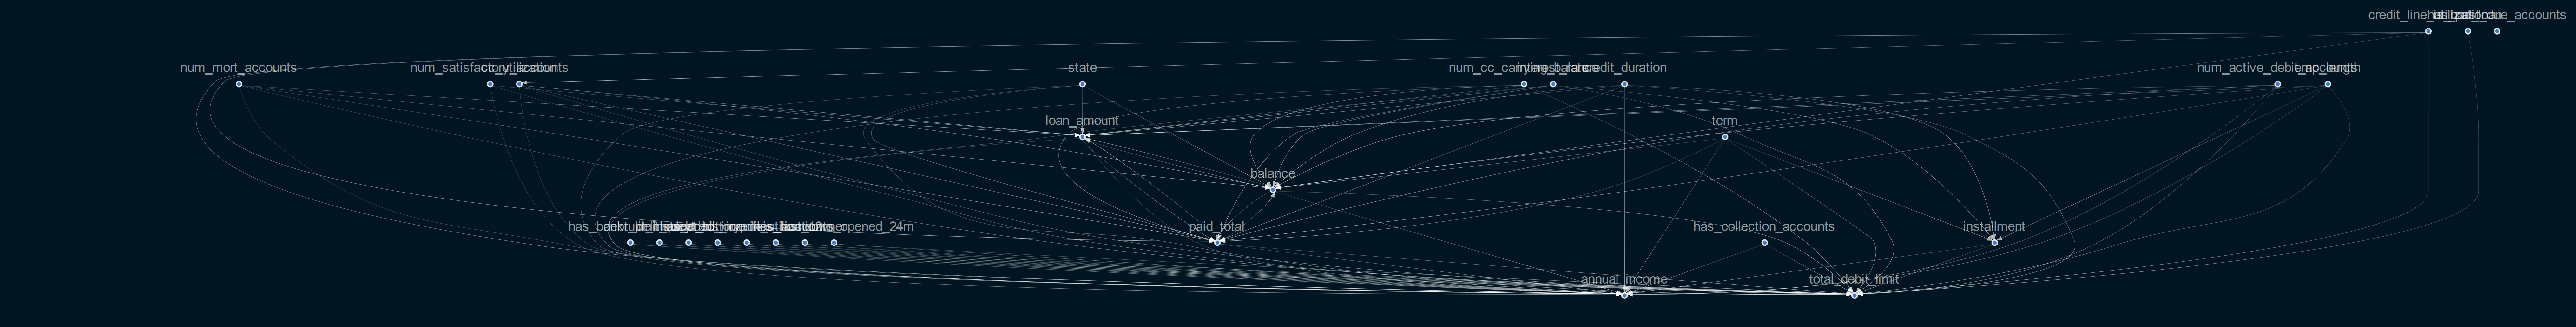

In [61]:
viz = plot_structure(
    sm,
    prog="dot",
    graph_attributes={"scale": "0.5"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK)
Image(viz.draw(format='png'))

In [58]:
print(viz.string())
dot_file = open("causalnex_initial1.dot", "w")
n = dot_file.write(viz.string())
dot_file.close()

strict digraph "" {
	graph [bb="0,0,1742.7,204",
		bgcolor="#001521",
		dpi=300,
		fontcolor="#FFFFFFD9",
		fontname=Helvetica,
		overlap=scale,
		pad="0.8,0.3",
		scale=0.5,
		splines=True
	];
	node [label="\N"];
	emp_length	[color="#FFFFFFD9",
		fillcolor="#4a90e2d9",
		fixedsize=True,
		fontcolor="#FFFFFF8c",
		fontname=Helvetica,
		fontsize=10,
		height=0.055556,
		label="emp_length

 ",
		penwidth=1,
		pos="1612.7,162",
		shape=circle,
		style=filled,
		width=0.055556];
	annual_income	[color="#FFFFFFD9",
		fillcolor="#4a90e2d9",
		fixedsize=True,
		fontcolor="#FFFFFF8c",
		fontname=Helvetica,
		fontsize=10,
		height=0.055556,
		label="annual_income

 ",
		penwidth=1,
		pos="1080.7,2",
		shape=circle,
		style=filled,
		width=0.055556];
	emp_length -> annual_income	[arrowhead=normal,
		arrowsize=0.4,
		color="#ffffff33;0.03:#ffffff36;0.03:#ffffff3a;0.03:#ffffff3e;0.03:#ffffff42;0.03:#ffffff46;0.03:#ffffff4a;0.03:#ffffff4e;0.03:#ffffff52;\
0.03:#ffffff56;0.03:#ffffff5a;0.03:#ffffff5e